<h2 align="center"> Regressor using Maximum Correntropy Criterion (MCC) and Minimum Error Entropy (MEE) criterion</h2>

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

def train_regressor(x, z, Wi, method='MSE', sigma=1.0, lr=0.01, niter=1000):    
    global fx
    w1 = Wi[0]
    w2 = Wi[1]
    w3 = Wi[2]
    IEP = np.zeros(shape=(niter,))    
    N = len(x)
    if method is 'MEE':
        dx = np.tile(x, (N, 1))
        dx -= dx.T
        dx2 = np.tile(x**2, (N, 1))
        dx2 -= dx2.T
    for k in range(0, niter):
        e = z - (w1 + w2*x + w3*x**2)
        IEP[k] = np.mean(np.power(w1 + w2*x + w3*x**2 - a - b*x - c*x**2, 2.0))
        if method is 'MCC':
            ge = np.exp(-0.5*np.power(e, 2.0)/sigma**2)/(np.sqrt(2.0*np.pi)*sigma**3)
            # Additional -1.0 in the gradients because we are doing gradient descent (not ascent)
            gradw1 = -1.0*np.sum(np.multiply(ge, e))/N
            gradw2 = -1.0*np.sum(np.multiply(np.multiply(ge, e), x))/N
            gradw3 = -1.0*np.sum(np.multiply(np.multiply(ge, e), x**2))/N
        elif method is 'MSE':
            gradw1 =  -2.0*np.sum(e)/N
            gradw2 =  -2.0*np.sum(np.multiply(e, x))/N
            gradw3 =  -2.0*np.sum(np.multiply(e, x**2))/N
        elif method is 'MEE':
            de = np.tile(e, (N, 1))
            de -= de.T
            gradw1 = 0.0 # MEE cannot find the mean
            gradw2 = -1.0*np.sum(np.multiply(np.multiply(np.exp(-0.5*np.power(de, 2.0)/sigma**2), de), dx))/(np.sqrt(2.0*np.pi)*(sigma**3)*(N**2))
            gradw3 = -1.0*np.sum(np.multiply(np.multiply(np.exp(-0.5*np.power(de, 2.0)/sigma**2), de), dx2))/(np.sqrt(2.0*np.pi)*(sigma**3)*(N**2))
        w1 -= lr*gradw1
        w2 -= lr*gradw2
        w3 -= lr*gradw3
    return [w1, w2, w3], IEP

### Generate training data
$$
f(x) = a + bx + cx^2
$$
$$
z = f(x) + Gaussiannoise + Impulsivenoise
$$

In [2]:
a = -3.0 
b = 5.0
c = -2.0
N = 100
x = np.linspace(-2.0, 2.0, num=N);
fx = a + b*x + c*x**2
nu = np.random.randn(N,)*np.std(fx)*0.25
nu[np.random.rand(N,) > 0.8] += 10.0*np.std(fx)*0.25
z = fx + nu

### Train regressors

In [3]:
wi = np.random.rand(3);
# 1000 iterations of MSE
[wMSE, IEPE] = train_regressor(x, z, wi, method='MSE', lr=0.01, niter=1000)
# 200 iterations of MSE + 800 iterations of MCC and MEE
[w_tmp, IEPE_tmp] = train_regressor(x, z, wi, method='MSE', lr=0.01, niter=200)
[wMCC, IEPC] = train_regressor(x, z, w_tmp, method='MCC', sigma=2.0, lr=1.0, niter=800)
[wMEE, IEPEE] = train_regressor(x, z, [0.0, w_tmp[1], w_tmp[2]], method='MEE', sigma=2.0, lr=1.0, niter=800)

### Performance plots

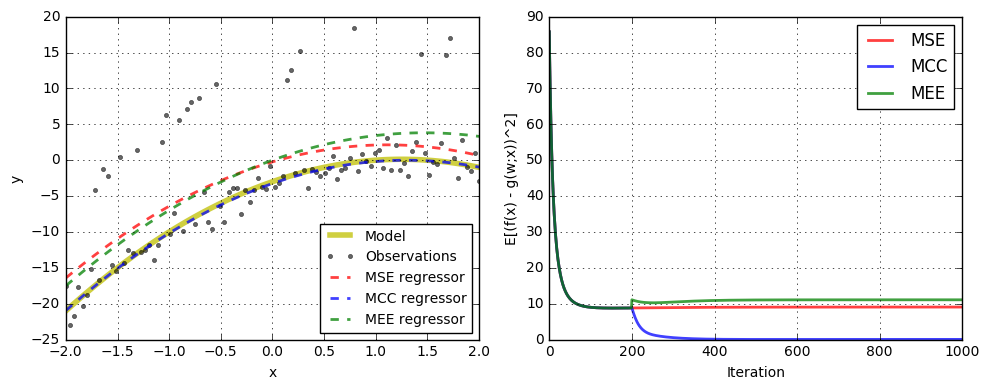

In [4]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x, fx, 'y-', label='Model', linewidth=4, alpha=0.75)
ax.plot(x, z, 'k.', label='Observations', alpha=0.6)
D = np.stack((len(x)*[1.0], x, x**2))
ax.plot(x, np.dot(wMSE, D), 'r--', label='MSE regressor', alpha=0.75, linewidth=2)
ax.plot(x, np.dot(wMCC, D), 'b--', label='MCC regressor', alpha=0.75, linewidth=2)
ax.plot(x, np.dot(wMEE, D), 'g--', label='MEE regressor', alpha=0.75, linewidth=2)
plt.xlabel('x') 
plt.ylabel('y')
plt.grid()
plt.legend(loc='lower right', fontsize=10)
ax = fig.add_subplot(1, 2, 2)
Niter = len(IEPE)
ax.plot(np.arange(0, Niter), IEPE, 'r-', label='MSE', linewidth=2, alpha=0.75)
ax.plot(np.arange(0, Niter), np.concatenate((IEPE_tmp, IEPC)), 'b-', 
        linewidth=2, label='MCC', alpha=0.75)
ax.plot(np.arange(0, Niter), np.concatenate((IEPE_tmp, IEPEE)), 'g-', 
        linewidth=2, label='MEE', alpha=0.75)
plt.xlabel('Iteration');
plt.ylabel('E[(f(x) - g(w;x))^2]')
plt.grid()
plt.legend()

plt.tight_layout()

In [5]:
print("Comparison between regressor weights:")
print("Targets: a = %0.4f, b = %0.4f, c = %0.4f"  % (a, b, c))
print("MSE: w1 = %0.4f, w2 = %0.4f, w3 = %0.4f"  % (wMSE[0], wMSE[1], wMSE[2]))
print("MCC: w1 = %0.4f, w2 = %0.4f, w3 = %0.4f"  % (wMCC[0], wMCC[1], wMCC[2]))
print("MEE: w1 = %0.4f, w2 = %0.4f, w3 = %0.4f"  % (wMEE[0], wMEE[1], wMEE[2]))

Comparison between regressor weights:
Targets: a = -3.0000, b = 5.0000, c = -2.0000
MSE: w1 = -0.2368, w2 = 4.2639, w3 = -1.9137
MCC: w1 = -3.2507, w2 = 5.0003, w3 = -1.9297
MEE: w1 = 0.0000, w2 = 5.2064, w3 = -1.7745


### Probability density function of the error

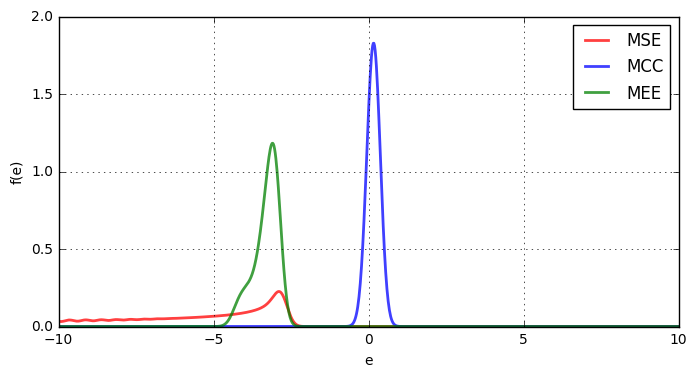

In [6]:
from sklearn.neighbors.kde import KernelDensity

x_plot = np.linspace(-10, 10, 1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
fig = plt.figure(figsize=(8, 4), dpi=80)
ax = fig.add_subplot(1, 1, 1)
kde.fit((fx - wMSE[0] - wMSE[1]*x - wMSE[1]*x**2)[:, np.newaxis])
ax.plot(x_plot, np.exp(kde.score_samples(x_plot)), 'r-', label='MSE', linewidth=2, alpha=0.75)
kde.fit((fx - wMCC[0] - wMCC[1]*x - wMCC[2]*x**2)[:, np.newaxis])
ax.plot(x_plot, np.exp(kde.score_samples(x_plot)), 'b-', label='MCC', linewidth=2, alpha=0.75)
kde.fit((fx - wMEE[0] - wMEE[1]*x - wMEE[2]*x**2)[:, np.newaxis])
ax.plot(x_plot, np.exp(kde.score_samples(x_plot)), 'g-', label='MEE', linewidth=2, alpha=0.75)
plt.xlabel('e')
plt.ylabel('f(e)');
plt.legend()
plt.grid()